##**Text Classification - FastText**

#### Install necessary libraries

In [1]:
!pip install fasttext

  Using cached fasttext-0.9.2.tar.gz (68 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Running setup.py clean for fasttext
Failed to build fasttext


  error: subprocess-exited-with-error
  
  python setup.py bdist_wheel did not run successfully.
  exit code: 1
  
  [75 lines of output]
  C:\Python312\Lib\site-packages\setuptools\dist.py:472: SetuptoolsDeprecationWarning: Invalid dash-separated options
  !!
  
          ********************************************************************************
          Usage of dash-separated 'description-file' will not be supported in future
          versions. Please use the underscore name 'description_file' instead.
  
          By 2024-Sep-26, you need to update your project and remove deprecated calls
          or your builds will no longer be supported.
  
          See https://setuptools.pypa.io/en/latest/userguide/declarative_config.html for details.
          ********************************************************************************
  
  !!
    opt = self.warn_dash_deprecation(opt, section)
  running bdist_wheel
  running build
  running build_py
  creating build
  creating bu

#### Import necessary libraries

In [1]:
import re
import nltk
import fasttext
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

#### Download necessary NLTK data

In [2]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

#### Load the dataset

In [3]:
# Load the text classsification dataset
df = pd.read_csv("Inputs.csv",names = ["inputs", "category"], header=None)
print(df.shape)
df.head(6)

(3309, 2)


,inputs,category
0,senior technical support engineer,IT
1,head of it services,IT
2,js front end engineer,IT
3,privileged access management expert,IT
4,devops engineers,IT
5,data modeller,IT


In [4]:
# Drop NA values
df.dropna(inplace=True)

In [5]:
# Identify the unique categories
df.category.unique()

array(['IT', 'Creative_Design', 'Business_Professional', 'Basic',
       'Student_Education', 'Gaming'], dtype=object)

In [6]:
# Number of records belonging to each category
category_counts = df["category"].value_counts()
print(category_counts)

category
IT                       1288
Business_Professional     938
Student_Education         729
Gaming                    142
Basic                     111
Creative_Design           101
Name: count, dtype: int64


#### Preprocess the text data

*   Removing punctuation
*   Convert to lowercase
*   Remove extra spaces
*   Tokenize
*   Remove stopwords
*   Perform stemming

In [7]:
# Combine label and inputsth a preprocessing step
df['category'] = '__label__' + df['category'].astype(str)

def preprocess_with_stemming(text):
    # Remove punctuation and make lowercase
    text = re.sub(r'[^\w\s]', '', text).lower()
    # Remove extra spaces
    text = re.sub(' +', ' ', text)
    # Tokenization
    word_tokens = word_tokenize(text)
    return ' '.join(word_tokens)

# def preprocess_with_stemming(text):
#     # Initialize the Porter Stemmer
#     stemmer = PorterStemmer()

#     # Remove punctuation and make lowercase
#     text = re.sub(r'[^\w\s]', '', text).lower()

#     # Remove extra spaces
#     text = re.sub(' +', ' ', text)

#     # Tokenization
#     word_tokens = word_tokenize(text)

#     # Stemming and join the words back into a string
#     stemmed_words = [stemmer.stem(word) for word in word_tokens]
#     return ' '.join(stemmed_words)

df['sentence_description'] = df['category'] + ' ' + df['inputs'].map(preprocess_with_stemming)

#### Split data for training and testing - 20%

In [8]:
# Split data for training and testing
train, test = train_test_split(df, test_size=0.2, random_state=40)

# Save training and testing data to files
train.to_csv("laptop.train", columns=["sentence_description"], index=False, header=False)
test.to_csv("laptop.test", columns=["sentence_description"], index=False, header=False)

#### Train the FastText model

In [9]:
# Train the FastText model
model = fasttext.train_supervised(input="laptop.train", lr=0.5, epoch=25, wordNgrams=2, minCount=1)

#### Evaluate model performance

In [10]:
# Evaluate and print model performance
print(model.test("laptop.test"))

(662, 0.8474320241691843, 0.8474320241691843)


#### Confusion matrix and Classification report

Confusion Matrix:
[[ 14   6   0   0   1   5]
 [  0 179   0   0  10  13]
 [  0   3  18   0   2   0]
 [  0   0   0  22   0   9]
 [  0  22   0   0 205   2]
 [  3  16   0   1   8 123]]

Classification Report:
                       precision    recall  f1-score   support

                Basic       0.82      0.54      0.65        26
Business_Professional       0.79      0.89      0.84       202
      Creative_Design       1.00      0.78      0.88        23
               Gaming       0.96      0.71      0.81        31
                   IT       0.91      0.90      0.90       229
    Student_Education       0.81      0.81      0.81       151

             accuracy                           0.85       662
            macro avg       0.88      0.77      0.82       662
         weighted avg       0.85      0.85      0.85       662


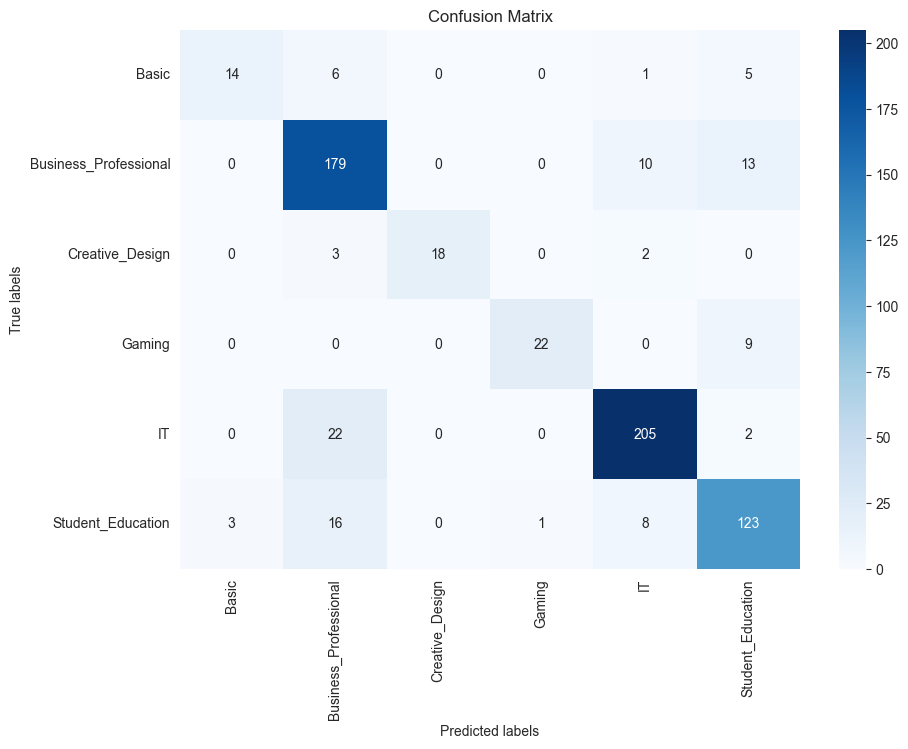

In [11]:
# Load the test data
test_df = pd.read_csv("laptop.test", names=["sentence_description"])

# Separate the labels and inputs
test_df[['true_labels', 'inputs']] = test_df['sentence_description'].str.split(' ',n=1, expand=True)

# Preprocess the inputs in the test set
test_df['processed_inputs'] = test_df['inputs'].apply(lambda x: preprocess_with_stemming(x))

# Predict labels for the test set inputs
predictions = test_df['processed_inputs'].apply(lambda sentence: model.predict(sentence)[0][0])

# Since predictions are returned as tuples, extract the first element which is the predicted label
test_df['predicted_labels'] = predictions

# Extract the labels (removing the '__label__' prefix for comparison and reporting)
test_df['true_labels'] = test_df['true_labels'].str.replace('__label__', '')
test_df['predicted_labels'] = test_df['predicted_labels'].str.replace('__label__', '')

# Generate and print the confusion matrix
labels = np.unique(test_df['true_labels'])
conf_matrix = confusion_matrix(test_df['true_labels'], test_df['predicted_labels'], labels=labels)
print("Confusion Matrix:")
print(conf_matrix)

# Generate and print the classification report
print("\nClassification Report:")
print(classification_report(test_df['true_labels'], test_df['predicted_labels'], labels=labels))

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

#### Test with custom inputs

In [12]:
# function for preprocessing individual inputs
def preprocess_input(input):
    # Preprocess the input
    preprocessed_title = preprocess_with_stemming(input)  # Use the same preprocessing function used for training
    return preprocessed_title

# List of inputs to test
inputs_to_test = ["Software Engineer", "Graphic Designer", "Marketing lead",
                      "ml lecturer", "computer science", "event planner",
                      "primary educator", "UX/UI designer", "accounts assistant",
                      "project lead", "intern finance analyst"]


# Preprocess the inputs
preprocessed_titles = [preprocess_input(title) for title in inputs_to_test]

# Predict categories for the preprocessed inputs
for title in preprocessed_titles:
    prediction = model.predict(title)
    print(f"input: {title}, Predicted Category: {prediction[0][0].replace('__label__', '')}")


input: software engineer, Predicted Category: IT
input: graphic designer, Predicted Category: Creative_Design
input: marketing lead, Predicted Category: Business_Professional
input: ml lecturer, Predicted Category: IT
input: computer science, Predicted Category: IT
input: event planner, Predicted Category: Business_Professional
input: primary educator, Predicted Category: Student_Education
input: uxui designer, Predicted Category: Creative_Design
input: accounts assistant, Predicted Category: Business_Professional
input: project lead, Predicted Category: IT
input: intern finance analyst, Predicted Category: IT


#### Save the trained model

In [13]:
model.save_model("input_classificationNew.bin")